# Prediction

## Load preprocessed dataframes

In [1]:
from utils import *

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

train_df.head()

,disp_id,client_id,account_id,client_count,loan_id,date,amount_x,duration,payments,status,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,district_id_y,frequency,trans_id,type,operation,amount_y,balance
0,2,2,2,2,4959,940105,80952,24,3373,1,...,167,85677,99107,1,1.0,276,credit,1.0,1100.0,1100.0
1,2,2,2,2,4959,940105,80952,24,3373,1,...,167,85677,99107,1,1.0,279,credit,2.0,20236.0,21336.0
2,2,2,2,2,4959,940105,80952,24,3373,1,...,167,85677,99107,1,1.0,697,credit,1.0,3700.0,25036.0
3,2,2,2,2,4959,940105,80952,24,3373,1,...,167,85677,99107,1,1.0,3530483,credit,NaN,13.5,25049.5
4,2,2,2,2,4959,940105,80952,24,3373,1,...,167,85677,99107,1,1.0,280,credit,2.0,20236.0,45285.5


## Columns to drop and feature target

In [2]:
columns_to_drop = ["disp_id", "client_id", "account_id", "loan_id", "district_id_x", "district_id_y", "trans_id"]
target_column = "status"

train_df.drop(columns_to_drop, axis=1).head()

,client_count,date,amount_x,duration,payments,status,sex,age,code,name,...,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,frequency,type,operation,amount_y,balance
0,2,940105,80952,24,3373,1,1,53,1,Hl.m. Praha,...,0.29,0.43,167,85677,99107,1.0,credit,1.0,1100.0,1100.0
1,2,940105,80952,24,3373,1,1,53,1,Hl.m. Praha,...,0.29,0.43,167,85677,99107,1.0,credit,2.0,20236.0,21336.0
2,2,940105,80952,24,3373,1,1,53,1,Hl.m. Praha,...,0.29,0.43,167,85677,99107,1.0,credit,1.0,3700.0,25036.0
3,2,940105,80952,24,3373,1,1,53,1,Hl.m. Praha,...,0.29,0.43,167,85677,99107,1.0,credit,NaN,13.5,25049.5
4,2,940105,80952,24,3373,1,1,53,1,Hl.m. Praha,...,0.29,0.43,167,85677,99107,1.0,credit,2.0,20236.0,45285.5


## Tune Models

### Decision Tree

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

# No feature selection
dt = tune_model(
    train_df, 
    DecisionTreeClassifier(),
    parameter_grid, 
    columns_to_drop, 
    target_column
)

plot_tree(dt.best_estimator_);

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python39\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Python39\lib\site-packages\sklearn\tree\_classes.py", line 165, in fit
    X, y = self._validate_data(
  File "C:\Python39\lib\site-packages\sklearn\base.py", line 569, in _validate_data
    X = check_array(X, **check_X_par

ValueError: could not convert string to float: 'Hl.m. Praha'

### SVM
Needs to be scaled (StandardScaler)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    # 'kernel': ['linear', 'poly', 'rbf']
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# No feature selection
svc = tune_model(
    train_df, 
    SVC(probability=True), 
    parameter_grid,
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

svc.best_estimator_

Best score: 0.9394668489405331
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


SVC(C=1, gamma=0.001, kernel='linear', probability=True)

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [ ]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

# No feature selection
knn = neighbors.KNeighborsClassifier()
knn = tune_model(
    train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.9394668489405331
Best parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 15}


### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

# No feature selection
nb = tune_model(
    train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.9153252382817602
Best parameters: {}


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

# No feature selection
rfc = tune_model(
    train_df, 
    RandomForestClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column
)

Best score: 0.9404047998784841
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100, 'n_jobs': -1}


## Comparing Models

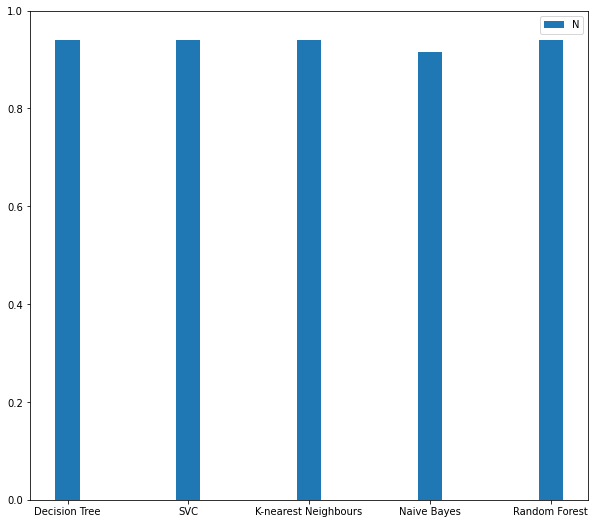

In [ ]:
import numpy as np

scores = {
    "Decision Tree" : [dt], #[dt_original, dt, dt_os_fs],
    "SVC" : [svc], #[svc_original, svc, svc_os_fs],
    "K-nearest Neighbours" : [knn], #[knn_original, knn, knn_os_fs],
    "Naive Bayes" : [nb], #[nb_original, nb, nb_os_fs],
    "Random Forest" : [rfc], #[rfc_original, rfc, rfc_os_fs]
}

labels ="No Feature selection" # ["No oversampling/No feature selection","No oversampling/Feature selection", "Oversampling/Feature selection"]

ind = np.arange(5)

plt.figure(figsize=(10,9))
plt.bar(ind, [i[0].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.2, [i[1].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.4, [i[2].best_score_ for i in scores.values()], 0.2)
plt.xticks(ind, scores.keys())
plt.legend(labels, loc=1)
plt.ylim(0, 1)
plt.show()

## Save results

In [ ]:
X_result = loan_test_df.drop(columns_to_drop, axis=1)

y_result = rfc.predict_proba(X_result)[:, 0]

result = pd.DataFrame({"Id": loan_test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)